In [24]:
from matplotlib.patches import Rectangle
def bbox_to_rect(bbox, im_size,conf):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return Rectangle(
        xy=(bbox[0]*im_size[0], bbox[1]*im_size[1]), width=bbox[2]*im_size[0], height=bbox[3]*im_size[1],
        fill=False, edgecolor='red', linewidth=5*conf)

In [2]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import json

import cv2
import torch
from tqdm import tqdm_notebook
from tqdm import tqdm
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
import torchvision

META_DIR = "data/metadata/metadata/"
TRAIN_DIR = "data/train/train/"
TEST_DIR = "data/test/test/"

test_data = json.load(open(META_DIR + 'iwildcam2022_test_information.json'))
train_data = json.load(open(META_DIR + 'iwildcam2022_train_annotations.json'))

#Test images
df_test = pd.DataFrame({'id': [item['id'] for item in test_data['images']],
                                'seq_id': [item['seq_id'] for item in test_data['images']],
                                'file_name': [item['file_name'] for item in test_data['images']],
                                'location': [item['location'] for item in test_data['images']],
                                'seq_num_frames': [item['seq_num_frames'] for item in test_data['images']],
                                'seq_frame_num': [item['seq_frame_num'] for item in test_data['images']]})
#Train images
df_train = pd.DataFrame({'id': [item['id'] for item in train_data['images']],
                                'seq_id': [item['seq_id'] for item in train_data['images']],
                                'file_name': [item['file_name'] for item in train_data['images']],
                                'location': [item['location'] for item in train_data['images']],
                                'seq_num_frames': [item['seq_num_frames'] for item in train_data['images']],
                                'seq_frame_num': [item['seq_frame_num'] for item in train_data['images']]})
# Detection for train test
detections = json.load(open(META_DIR+"iwildcam2022_mdv4_detections.json"))['images']
det_dict = dict()
for detection in tqdm(detections):
    det_dict[detection['file']] = detection['detections']
df_detection = pd.DataFrame({'file': [item['file'] for item in detections],
                                'detections': [item['detections'] for item in detections]})
# Test sequence ids
test_sequence_ids = pd.unique(df_test['seq_id'])
# Train sequence id and count
train_seq_count = pd.read_csv(META_DIR+"train_sequence_counts.csv")

/home/briancy2/.conda/envs/iwildcam/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 261428/261428 [00:00<00:00, 1550839.28it/s]


In [4]:
df_train.iloc[0]

id                    8b02698a-21bc-11ea-a13a-137349068a90
seq_id                30048d32-7d42-11eb-8fb5-0242ac1c0002
file_name         8b02698a-21bc-11ea-a13a-137349068a90.jpg
location                                                 3
seq_num_frames                                           6
seq_frame_num                                            0
Name: 0, dtype: object

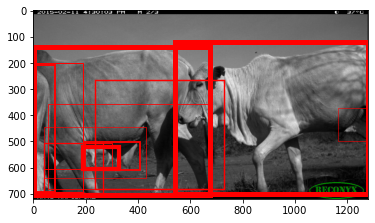

In [26]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
id = '2fff6c8a-7d42-11eb-8fb5-0242ac1c0002'
def func_anim(i, images, ax, detections):
    ax.imshow(images[i])
    [p.remove() for p in reversed(ax.patches)]
    for d in detections[i]:
        ax.add_patch(bbox_to_rect(d["bbox"], images[i].size, d["conf"]))
    return ax
img_rows = df_train.loc[df_train.seq_id == id]
images = []
detections_list = []
for index, img_row in img_rows.iterrows():
    detections = df_detection.loc[df_detection.file == ('train/'+img_row['file_name'])]['detections'].to_list()[0]
    image = Image.open(TRAIN_DIR+img_row['file_name'])
    images.append(image)
    detections_list.append(detections)
    
fig, ax = plt.subplots()
anim = FuncAnimation(
    fig=fig,
    func=func_anim,
    fargs=(images,ax, detections_list),        
    frames=len(images),
    interval=2000,
    blit=False,
)
writergif = animation.PillowWriter(fps=3)
anim.save(f"videos/{id}.gif", writer=writergif)
